In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mass = 10**np.linspace(np.log10(0.5), np.log10(12.0), 100)
porb = 10**np.linspace(np.log10(1), np.log10(10000), 100)

In [3]:
dat = []
for m1 in mass:
    for m2 in mass:
        for p in porb:
            dat.append([m1, m2, p])

In [4]:
dat = np.vstack(dat)

In [5]:
np.shape(dat)

(1000000, 3)

In [6]:
dat

array([[5.00000000e-01, 5.00000000e-01, 1.00000000e+00],
       [5.00000000e-01, 5.00000000e-01, 1.09749877e+00],
       [5.00000000e-01, 5.00000000e-01, 1.20450354e+00],
       ...,
       [1.20000000e+01, 1.20000000e+01, 8.30217568e+03],
       [1.20000000e+01, 1.20000000e+01, 9.11162756e+03],
       [1.20000000e+01, 1.20000000e+01, 1.00000000e+04]])

In [7]:
ind_save,  = np.where(dat[:,0] > dat[:,1])

In [8]:
len(ind_save)

495000

In [9]:
dat = dat[ind_save]

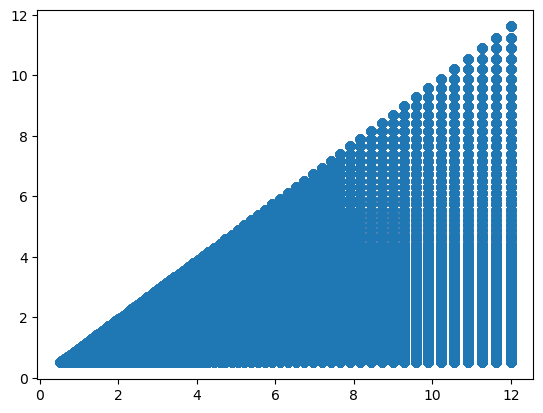

In [10]:
plt.scatter(dat[:,0], dat[:,1])

In [11]:
from cosmic import utils    

In [12]:
a = utils.a_from_p(m1=dat[:,0], m2=dat[:,1], p=dat[:,2])

In [13]:
def r_rl(m1, m2, a):
    q=m1/m2
    r = 0.49 * q**(2/3) / (0.6 * q**(2/3) + np.log(1 + q**(1/3)))
    
    return r * a

def get_roche_overflow(m1, m2, a, rad_interp):
    
    R_rl = r_rl(m1, m2, a)
    r_1 = rad_interp(m1)
    
    ind_overflow, = np.where(r_1 > R_rl)
    return ind_overflow

In [14]:
from cosmic.sample.initialbinarytable import InitialBinaryTable

from cosmic.evolve import Evolve

In [15]:
I = InitialBinaryTable.InitialBinaries(m1=mass, m2=np.zeros(100), porb=np.zeros(100), ecc=np.zeros(100), tphysf=1.0 * np.ones(100), 
                                       kstar1=np.ones(100) * 1, kstar2=np.ones(100) * 0, metallicity=np.ones(100) * 0.02)


In [16]:
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 'don_lim' : -1, 'acc_lim' : -1}


In [17]:
bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=I, BSEDict=BSEDict)

In [18]:
rad= bpp.groupby('bin_num').first().rad_1.values

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
rad_interp = interp1d(mass, rad)

In [21]:
ind_RRLO = get_roche_overflow(m1=dat[:,0], m2=dat[:,1], a=2, rad_interp=rad_interp)

In [22]:
dat = dat[ind_RRLO, :]

In [23]:
np.shape(dat)

(477100, 3)

In [24]:
np.savetxt('initial_grid_parameters.txt', dat, delimiter = ',', header='mass_1 [Msun], mass_2 [Msun], p_orb [day]')

In [25]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
final_kstar = range(0,15)


In [44]:
InitialBinaries, mass_singles, mass_binaries, n_singles, n_binaries = InitialBinaryTable.sampler(
    'independent', final_kstar, final_kstar, binfrac_model=1.0, primary_model='kroupa01', 
    ecc_model='sana12', porb_model='log_uniform', m2_min=0.08, SF_start=1.0, 
    SF_duration=0.0, met=0.02, size=1000000)


In [45]:
InitialBinaries['ecc'] = 0.0

In [46]:
primary_lower_bound = 0.7
primary_upper_bound = 12

In [47]:
InitialBinaries = InitialBinaries.loc[(InitialBinaries.mass_1 < primary_upper_bound) & (InitialBinaries.mass_1 > primary_lower_bound)]

In [65]:
InitialBinaries[['mass_1', 'mass_1', 'porb']].to_csv('initial_MC_sample.txt', sep=',', header=True, index=False)

In [48]:
len(InitialBinaries)

151724

In [49]:
bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=InitialBinaries, BSEDict=BSEDict)

In [59]:
sep = bpp.groupby('bin_num').first().sep.values
print(sep)

[  216.58029469  2567.51239557    99.51711912 ...  4151.52643051
 14453.46751667    48.35620629]


In [60]:
RRLO_1 = r_rl(initC.mass_1, initC.mass_2, sep)
print(RRLO_1)   

0           105.825822
10         1256.630683
16           46.429102
23         2756.498356
37         3811.405379
              ...     
999971    45936.163461
999974        6.484688
999986     2040.814279
999988     6558.380653
999991       19.938918
Length: 151724, dtype: float64


In [61]:
np.where(initC.rad_1 > RRLO_1)

(array([], dtype=int64),)

In [ ]:
ind_RRLO = get_roche_overflow(m1=initC.mass_1, m2=initC.mass_2, a=initC.sep, rad_interp=rad_interp)